In [140]:
from polymer import *
import numpy as np
import math as m
import matplotlib.pyplot as plt

Ndims = 2
Nbeads= 7
chain = polymer(Ndims = Ndims, Nbeads = Nbeads)

print("Initial chain energy = ", chain.energy())


Initial chain energy =  -0.07344484119499989


In [141]:
def bin_index(x, bin_edges):

    bin_range = bin_edges[-1] - bin_edges[0]
    bin_pos = x - bin_edges[0]

    return int( (bin_pos/bin_range)*(len(bin_edges)-1.0) )

In [142]:
def chainplot(inchain):
    
    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches

    circles = list()

    for ibead in range(chain.Nbeads):
        circles.append(mpatches.Circle(chain.rpos[ibead],radius=chain.R))

    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')

    for circle in circles:
        ax.add_patch(circle)

    xpoints = chain.rpos[:,0]
    ypoints = chain.rpos[:,1]
    bonds, = ax.plot(xpoints,ypoints)
    ax.set(xlim=(-7, 7),ylim=(-7, 7))

    return fig, ax, bonds

In [143]:
def run_wl_sweeps(chain, bin_edges, wl_hist, wl_logdos, wl_f, Nsweeps=100, max_disp=0.15, sample_int=100):
    """ Runs Nsweeps MC sweeps where one sweep is on average at attempt to move each mobile bead on the chain at least once.
        Returns a  """

    # Initialise sampling for the current set of sweeps
    samples = []
    acount  = 0

    old_energy = chain.energy()
    
    for itrial in range(Nsweeps*(chain.Nbeads-1)):

        # Randomly choose any bead but the first
        ibead = np.random.randint(1, chain.Nbeads) # first bead never moves

        disp = 2.0*np.random.random_sample(2)-1.0
        disp = disp*max_disp

        old_local_energy = chain.local_energy(ibead)
        
        ibin = bin_index(old_energy, bin_edges)
        
        chain.rpos[ibead] = chain.rpos[ibead] + disp
    
        new_local_energy = chain.local_energy(ibead)

        new_energy = old_energy + ( new_local_energy - old_local_energy )

        
        jbin = bin_index(new_energy, bin_edges)

        #print("Proposing move from ",ibin, " to ", jbin)
        
        if jbin in range (0, len(wl_hist)):

            try:
            
                if np.random.sample() < m.exp(wl_logdos[ibin]-wl_logdos[jbin]):
                    # accepted
                    acount = acount + 1
                    old_energy = new_energy
                    
                    #print("Accepted move from ",ibin, " to ", jbin)
                
                else:
                    # reject and reset
                    chain.rpos[ibead] = chain.rpos[ibead] - disp
                    jbin = ibin

                wl_hist[jbin] += 1
                wl_logdos[jbin] += wl_f

            except:

                print("Indexing error: ", old_energy, new_energy, ibin, jbin)
                
                return

        else:

            # reject and reset
            chain.rpos[ibead] = chain.rpos[ibead] - disp
            jbin = ibin
            
        
        
        if itrial%sample_int*(chain.Nbeads-1)==0:
            samples.append((chain.energy(), chain.end2end()))

        

    
    return chain, samples, wl_hist, wl_logdos, acount/(Nsweeps*(chain.Nbeads-1))    

Starting sampling from bin  29
Number of bins :  50


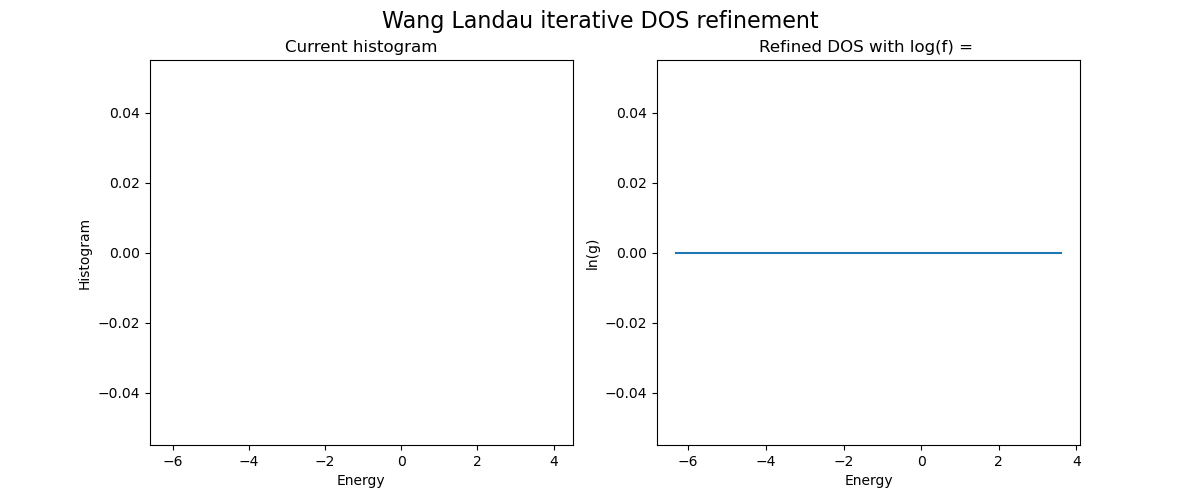

In [144]:
# Initialise wl_simulation

# Define energy range and bins
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

print("Starting sampling from bin ", bin_index(chain.energy(), bin_edges))

# Initialise histogram and log of DOS
wl_hist   = np.zeros(len(bin_edges)-1)
wl_logdos = np.zeros(len(bin_edges)-1)

print("Number of bins : ", len(wl_hist))

# Setup some plots
%matplotlib widget
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(bin_edges[:-1], wl_hist,   width=bin_width,align='edge')
ax2.plot(bin_edges[:-1]+0.5*bin_width, wl_logdos)
ax1.set_xlabel('Energy')
ax2.set_xlabel('Energy')
ax1.set_ylabel('Histogram')
ax2.set_ylabel('ln(g)')
fig.suptitle('Wang Landau iterative DOS refinement', fontsize=16)
ax1.set_title('Current histogram')
ax2.set_title('Refined DOS with log(f) = ')
plt.show()


In [ ]:
!ls

In [146]:



from ipywidgets import IntProgress
from IPython.display import display
import time


Nframes = 1000
f = IntProgress(min=0, max=Nframes) # instantiate the bar
samples = []

display(f) # display the bar

wl_f = 0.005

first_reset = False

#for iframe in range(Nframes):
while ( wl_f > 1E-9):
    

    chain, new_samples, wl_hist, wl_logdos, ratio = run_wl_sweeps(chain, bin_edges, wl_hist, wl_logdos, wl_f, Nsweeps=100, max_disp=0.12, sample_int = 100)
    #f.value +=1  # Increment progress bar

    flatness = 100*np.min(wl_hist)/np.mean(wl_hist)
    
    ax1.cla(), ax2.cla()
    ax1.bar(bin_edges[:-1], wl_hist,   width=bin_width,align='edge')
    ax2.plot(bin_edges[:-1]+0.5*bin_width, wl_logdos)
    ax1.set_xlabel('Energy')
    ax2.set_xlabel('Energy')
    ax1.set_ylabel('Histogram')
    ax2.set_ylabel('ln(g)')
    fig.suptitle('Wang Landau iterative DOS refinement', fontsize=16)
    ax1.set_title('Current histogram, flatness = ' + str(round(flatness,2))+'%')
    ax2.set_title('Refined DOS with log(f) = '+str(wl_f))
    
    plt.draw()
    
    #fig.canvas_draw()
    #fig.canvas_flush_events()
    fig.canvas.draw()
    fig.canvas.flush_events()

    if (np.min(wl_hist) > 10):
    
        if ( first_reset == False ):
            first_reset = True
            wl_hist = np.zeros(len(bin_edges)-1)
    
        else:

            if flatness > 95.0 :
                wl_hist = np.zeros(len(bin_edges)-1)
                wl_f = wl_f * 0.5
                print("Reduced f ", wl_f*2 , " -> ", wl_f)
                min_logdos = np.min(wl_logdos)
                wl_logdos = wl_logdos - min_logdos

                filename = 'dos_f'+str(wl_f)+'.txt'
                np.savetxt(filename, wl_logdos)


IntProgress(value=0, max=1000)

Reduced f  0.005  ->  0.0025
Reduced f  0.0025  ->  0.00125
Reduced f  0.00125  ->  0.000625
Reduced f  0.000625  ->  0.0003125
Reduced f  0.0003125  ->  0.00015625
Reduced f  0.00015625  ->  7.8125e-05
Reduced f  7.8125e-05  ->  3.90625e-05


KeyboardInterrupt: 

Starting sampling from bin  30
Number of bins :  50


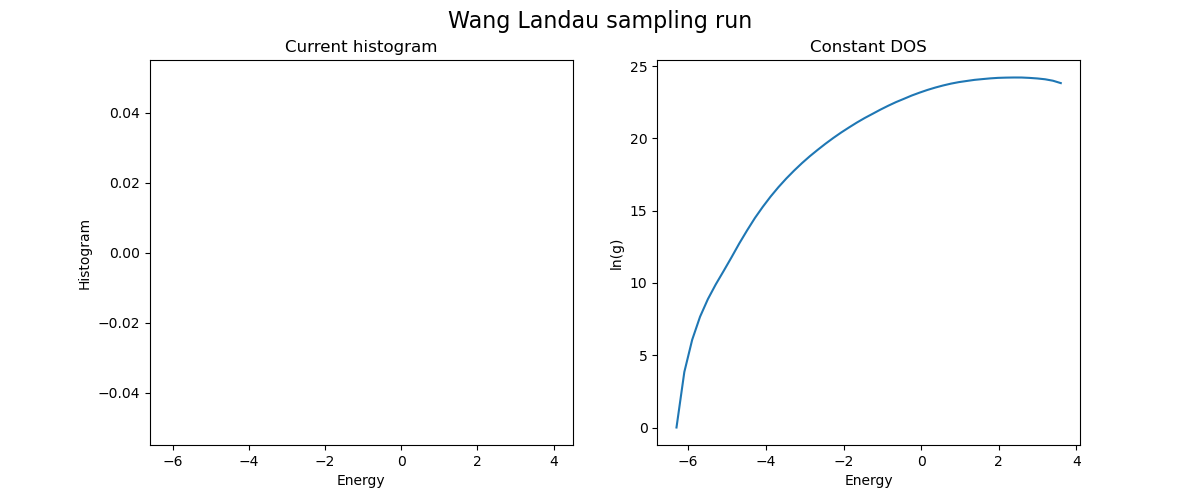

In [17]:
# Initialise wl_simulation

# Define energy range and bins
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

print("Starting sampling from bin ", bin_index(chain.energy(), bin_edges))

# Initialise histogram and log of DOS
wl_hist   = np.zeros(len(bin_edges)-1)

# Load DOS I made earlier
filename = 'dos_f4.8828125e-06.txt'
wl_logdos = np.loadtxt(filename)

# Initialise sampled quantities
samples = []

print("Number of bins : ", len(wl_hist))

# Setup some plots
%matplotlib widget
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(bin_edges[:-1], wl_hist,   width=bin_width,align='edge')
ax2.plot(bin_edges[:-1]+0.5*bin_width, wl_logdos)
ax1.set_xlabel('Energy')
ax2.set_xlabel('Energy')
ax1.set_ylabel('Histogram')
ax2.set_ylabel('ln(g)')
fig.suptitle('Wang Landau sampling run', fontsize=16)
ax1.set_title('Current histogram')
ax2.set_title('Constant DOS')
plt.show()

In [23]:
from ipywidgets import IntProgress
from IPython.display import display
import time


Nframes = 1000
f = IntProgress(min=0, max=Nframes) # instantiate the bar


display(f) # display the bar

wl_f = 0.0

for iframe in range(Nframes):
#while ( wl_f > 1E-9):
    

    chain, new_samples, wl_hist, wl_logdos, ratio = run_wl_sweeps(chain, bin_edges, wl_hist, wl_logdos, wl_f, Nsweeps=100, max_disp=0.12, sample_int = 100)
    samples = samples + new_samples
    f.value +=1  # Increment progress bar

    flatness = 100*np.min(wl_hist)/np.mean(wl_hist)
    
    ax1.cla(), ax2.cla()
    ax1.bar(bin_edges[:-1], wl_hist,   width=bin_width,align='edge')
    ax2.plot(bin_edges[:-1]+0.5*bin_width, wl_logdos)
    ax1.set_xlabel('Energy')
    ax2.set_xlabel('Energy')
    ax1.set_ylabel('Histogram')
    ax2.set_ylabel('ln(g)')
    fig.suptitle('Wang Landau sampling run', fontsize=16)
    ax1.set_title('Current histogram')
    ax2.set_title('Constant DOS')
    
    plt.draw()
    
    #fig.canvas_draw()
    #fig.canvas_flush_events()
    fig.canvas.draw()
    fig.canvas.flush_events()

    # Save histogram
    filename = 'histogram_f4.8828125e-06.txt'
    np.savetxt(filename, wl_hist)

    #filename = 'samples_f4.8828125e-06.dat'
    #FILE = open(filename,"w")
    #samples.tofile(FILE)
    #FILE.close()


IntProgress(value=0, max=1000)

Text(0, 0.5, 'P(energy)')

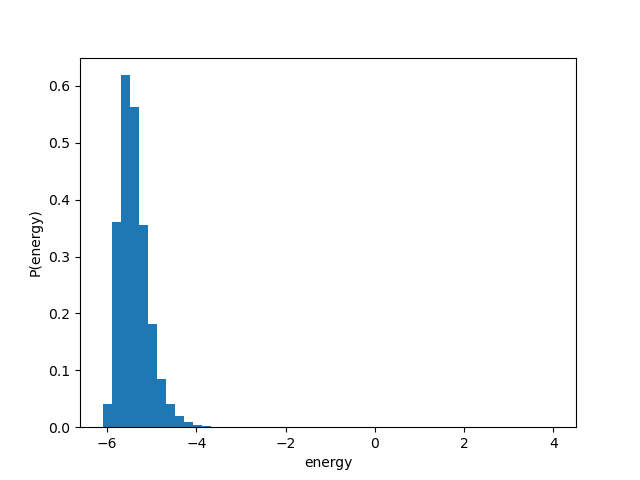

In [49]:
# Energy at some particular temperature assuming DOS is perfect

temperature = 0.12
beta = 1.0/temperature

prob = np.zeros(len(bin_edges)-1)

for ibin, edge in enumerate(bin_edges[:-1]):
    bin_energy = edge + 0.5*bin_width
    prob[ibin] = m.exp(wl_logdos[ibin]-beta*bin_energy)

prob = prob/sum(prob)
fig, ax = plt.subplots()
plt.bar(bin_edges[:-1],prob,width=bin_width,align='edge')
ax.set_xlabel('energy')
ax.set_ylabel('P(energy)')



Text(0, 0.5, 'P(energy)')

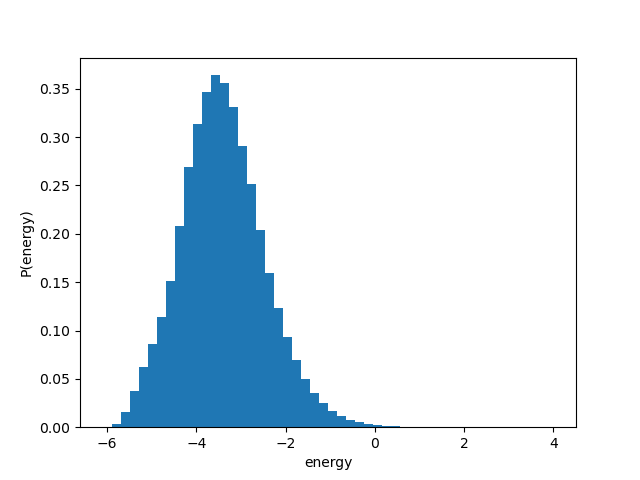

In [51]:
# Energy at some particular temperature using reweighted histogram

temperature = 0.3
beta = 1.0/temperature

prob = np.zeros(len(bin_edges)-1)

for ibin, edge in enumerate(bin_edges[:-1]):
    bin_energy = edge + 0.5*bin_width
    prob[ibin] = m.exp(wl_logdos[ibin]-beta*bin_energy)/wl_hist[ibin]

prob = prob/sum(prob)
fig, ax = plt.subplots()
plt.bar(bin_edges[:-1],prob,width=bin_width,align='edge')
ax.set_xlabel('energy')
ax.set_ylabel('P(energy)')

Mean energy at temperature  0.1  =  -5.850668052965237
Mean energy at temperature  0.11  =  -5.783207298968464
Mean energy at temperature  0.12  =  -5.711088117766869
Mean energy at temperature  0.13  =  -5.6324063200283065
Mean energy at temperature  0.13999999999999999  =  -5.5455545109648465
Mean energy at temperature  0.14999999999999997  =  -5.449540785497886
Mean energy at temperature  0.15999999999999998  =  -5.344235912631531
Mean energy at temperature  0.16999999999999998  =  -5.230451190625673
Mean energy at temperature  0.17999999999999997  =  -5.109806637795737
Mean energy at temperature  0.18999999999999995  =  -4.984431366422912
Mean energy at temperature  0.19999999999999996  =  -4.8565986669359775
Mean energy at temperature  0.20999999999999996  =  -4.728405085402467
Mean energy at temperature  0.21999999999999995  =  -4.601561910982105
Mean energy at temperature  0.22999999999999993  =  -4.477312115085153
Mean energy at temperature  0.23999999999999994  =  -4.356445915

Text(0, 0.5, '<E>')

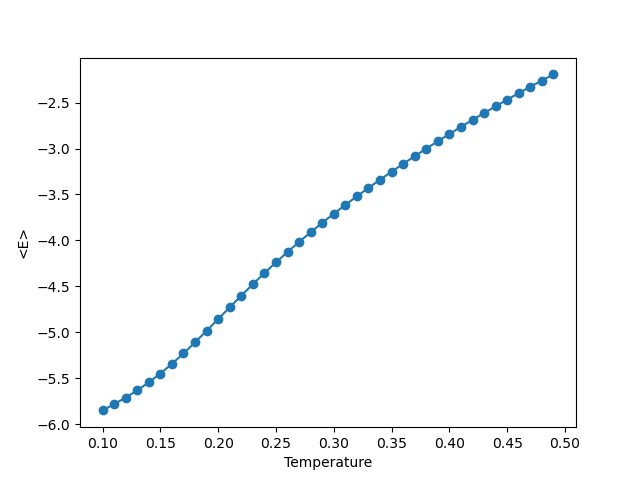

In [115]:
# Something more sophisticated

temperatures = np.arange(0.1,0.5,0.01)

mean_energies = np.zeros(len(temperatures))

for itemp, temperature in enumerate(temperatures):
    
    beta = 1.0/temperature
    prob = np.zeros(len(bin_edges)-1)

    for ibin, edge in enumerate(bin_edges[:-1]):
        bin_energy = edge + 0.5*bin_width
        prob[ibin] = m.exp(wl_logdos[ibin]-beta*bin_energy)/wl_hist[ibin]

    # Mean energy
    mean_energy = np.dot(bin_edges[:-1]+0.5*bin_width,prob)/np.sum(prob)
    print("Mean energy at temperature ", temperature, " = ",mean_energy)
    mean_energies[itemp] = mean_energy

fig, ax = plt.subplots()
plt.plot(temperatures, mean_energies,'o-')
ax.set_xlabel('Temperature')
ax.set_ylabel('<E>')


In [116]:
# Do something with the samples
energy_samples  = [ sample[0] for sample in samples ]
end2end_samples = [ sample[1] for sample in samples ]

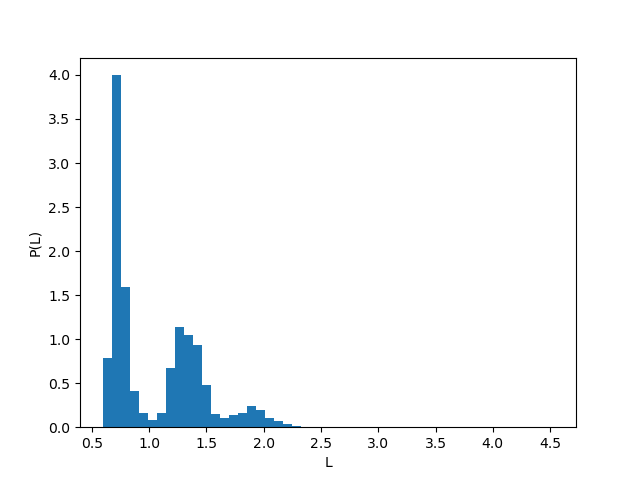

In [138]:
# End to end sample distribution at some temperature

temperature = 0.21
beta = 1.0/temperature

weights = np.zeros(len(energy_samples))

for isamp, sample_energy in enumerate(energy_samples):

    ibin = bin_index(sample_energy, bin_edges)
    edge = bin_edges[ibin]
    bin_energy = edge + 0.5*bin_width
    weights[isamp] = m.exp(wl_logdos[ibin]-beta*bin_energy)#/wl_hist[ibin]

min_e2e = np.min(end2end_samples) ; max_e2e = np.max(end2end_samples) 
e2ebins = np.histogram_bin_edges([min_e2e,max_e2e], bins=50)
counts, bins = np.histogram(end2end_samples,bins=e2ebins,weights=weights,density=True)



fig, ax = plt.subplots()
ax.hist(bins[:-1], bins, weights=counts)
ax.set_xlabel('L')
ax.set_ylabel('P(L)')
plt.show()



Text(0, 0.5, '<L>')

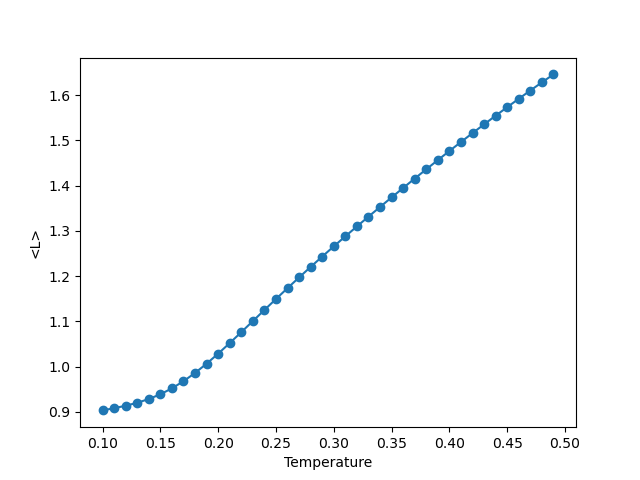

In [119]:
# End to end distance as a function of temperature
temperatures = np.arange(0.1,0.5,0.01)

mean_end2end = np.zeros(len(temperatures))

for itemp, temperature in enumerate(temperatures):
    
    beta = 1.0/temperature
    prob = np.zeros(len(bin_edges)-1)

    for isamp, sample_energy in enumerate(energy_samples):

        ibin = bin_index(sample_energy, bin_edges)
        edge = bin_edges[ibin]
        bin_energy = edge + 0.5*bin_width
        weights[isamp] = m.exp(wl_logdos[ibin]-beta*bin_energy)#/wl_hist[ibin]

    # Mean end to end distance
    mean_end2end[itemp] = np.dot(end2end_samples, weights)/np.sum(weights)
    #print("Mean end to end distance at temperature ", temperature, " = ",mean_end2end[itemp])

fig, ax = plt.subplots()
plt.plot(temperatures, mean_end2end,'o-')
ax.set_xlabel('Temperature')
ax.set_ylabel('<L>')

0.1 6.523143732851505
0.11 6.938878080971169
0.12 7.497178625245859
0.13 8.18733289265162
0.13999999999999999 8.97494558989295
0.14999999999999997 9.805279739473942
0.15999999999999998 10.612307071059567
0.16999999999999998 11.33084415262689
0.17999999999999997 11.908356564019398
0.18999999999999995 12.313058763908094
0.19999999999999996 12.536371471453162
0.20999999999999996 12.589999490924773
0.21999999999999995 12.499635074187074
0.22999999999999993 12.297805188940668
0.23999999999999994 12.017795053422699
0.24999999999999994 11.689550855796757
0.2599999999999999 11.337585215881784
0.2699999999999999 10.98042820125242
0.2799999999999999 10.63104502899272
0.2899999999999999 10.297726991769572
0.29999999999999993 9.985117193875482
0.3099999999999999 9.695177632302869
0.3199999999999999 9.42800947098778
0.3299999999999999 9.182502997806099
0.33999999999999986 8.956827584744637
0.34999999999999987 8.74878611677688
0.3599999999999999 8.556061516201517
0.3699999999999999 8.376380867399256

Text(0, 0.5, '<Cv>')

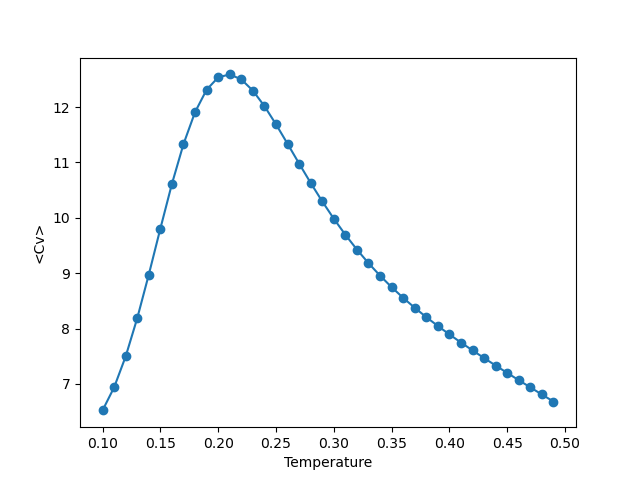

In [139]:
# Heat capacity as a function of temperature
temperatures = np.arange(0.1,0.5,0.01)

heat_cap = np.zeros(len(temperatures))

#energy_sq_samples = [energy**2 for energy in energy_samples]

for itemp, temperature in enumerate(temperatures):
    
    beta = 1.0/temperature
    prob = np.zeros(len(bin_edges)-1)

    for isamp, sample_energy in enumerate(energy_samples):

        ibin = bin_index(sample_energy, bin_edges)
        edge = bin_edges[ibin]
        bin_energy = edge + 0.5*bin_width
        weights[isamp] = m.exp(wl_logdos[ibin]-beta*bin_energy)/wl_hist[ibin]

    

    mean_energy = np.dot(energy_samples,weights)/np.sum(weights)
    delta_energy_sq = [(energy - mean_energy)**2 for energy in energy_samples]
    mean_deltaE_sq = np.dot(delta_energy_sq ,weights)/np.sum(weights)
    
    heat_cap[itemp] = mean_deltaE_sq/(temperature**2) #+ (Ndims/2)*(Nbeads-1)

    print(temperature, heat_cap[itemp])

fig, ax = plt.subplots()
plt.plot(temperatures, heat_cap,'o-')
ax.set_xlabel('Temperature')
ax.set_ylabel('<Cv>')

In [136]:
T_trans = temperatures[np.argmax(heat_cap)]; print(T_trans)

0.20999999999999996
